Loading Data

In [98]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
data_dir = "/kaggle/input/satellite-image-classification/data"

In [99]:
classes = [d for d in os.listdir(data_dir)]
print(classes)

['cloudy', 'desert', 'green_area', 'water']


In [100]:
for cls in classes:
    class_path = os.path.join(data_dir,cls)
    lenth = len(os.listdir(class_path))
    print(f"'{cls}' have {lenth} samples" )

'cloudy' have 1500 samples
'desert' have 1131 samples
'green_area' have 1500 samples
'water' have 1500 samples


In [101]:
# corruption detection
corrupted_files = []
for cls in classes:
    class_path = os.path.join(data_dir,cls)
    class_list = os.listdir(class_path)
    for i, m in enumerate(class_list):
        image_path = os.path.join(class_path, m)
        img = Image.open(image_path)
        try:
            img.verify()
        except Exception as e: 
            corrupted_files.append(m)
print(corrupted_files)

[]


Sample images of 'cloudy'
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: CMYK
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: CMYK
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: CMYK
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: CMYK


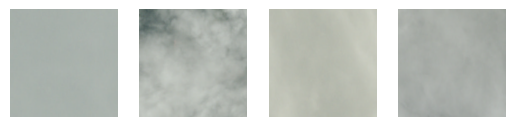

Sample images of 'desert'
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: RGB
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: RGB
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: RGB
Image format: JPEG
Image size (width x height): (256, 256)
Image mode: RGB


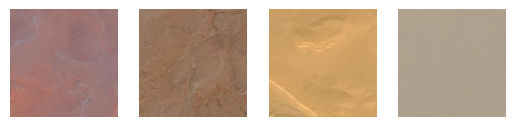

Sample images of 'green_area'
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB


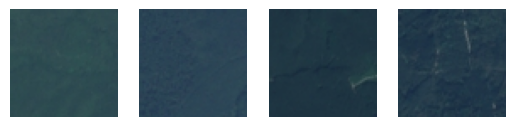

Sample images of 'water'
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB
Image format: JPEG
Image size (width x height): (64, 64)
Image mode: RGB


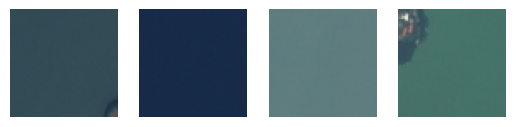

In [102]:
for cls in classes:
    print(f"Sample images of '{cls}'")
    class_path = os.path.join(data_dir,cls)
    class_list = os.listdir(class_path)
    samples = class_list[:4]
    
    for i, m in enumerate(samples):
        image_path = os.path.join(class_path, m)
        img = Image.open(image_path)
        print("Image format:", img.format)
        print("Image size (width x height):", img.size)
        print("Image mode:", img.mode)
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()
        

Data Preprocessing 

In [103]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets


In [104]:
# Normalize method (now using ImageNet) ?? Augment ??
train_transform = transforms.Compose([transforms.Lambda(lambda img: img.convert("RGB")),
                                transforms.Resize((224,224)),
                                transforms.TrivialAugmentWide(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                                     ])
val_test_transform = transforms.Compose([transforms.Lambda(lambda img: img.convert("RGB")),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
    
])

ImageNet uses 1.2 million for 224*224, try if tens of thousands works for transfer learning for satellite image

Splitting Data

In [105]:
dataset = datasets.ImageFolder(root = data_dir, transform = None)
print(len(dataset))

data_size = len(dataset)

train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

5631


In [106]:
# apply transform to subsets

class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform 

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

In [107]:
train_dataset = TransformSubset(train_set, train_transform)
val_dataset = TransformSubset(val_set, val_test_transform)
test_dataset = TransformSubset(test_set, val_test_transform)


In [108]:
batch_size = 32
train_loader= DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader= DataLoader(val_dataset, batch_size = batch_size)
test_loader= DataLoader(test_dataset, batch_size = batch_size)

In [109]:
print(len(test_dataset))

846


Model 

In [110]:
import torchvision.models as models
import copy
def get_resnet(num_classes):
    model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rsmodel = get_resnet(num_classes).to(device)

print(rsmodel)
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [111]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rsmodel.parameters(), lr = 0.001)
lrscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

In [112]:
# Train loop

def train_model(model, train_loader, val_loader, epochs, patience, delta):
    model = model.to(device)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improve = 0 

    for epoch in range(epochs):
        model.train()
        runloss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            runloss += loss.item() * inputs.size(0)

        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs ,1)
                correct += torch.sum(preds == labels.data)

        train_loss = runloss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        lrscheduler.step()
        print(f"Epochs{epoch+1}")
        print(f"Train_loss{train_loss:.4f}, val_loss{val_loss:.4f}, val_acc{val_acc:.2f}")
        if val_acc > best_acc + delta:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            no_imporve = 0
        else:
            no_improve +=1
        if no_improve >= patience:
            break
    model.load_state_dict(best_model_wts)
    return model


Train


In [113]:
# add early stop
epochs = 20
patience = 5
delta = 0.002
model = train_model(rsmodel, train_loader, val_loader, epochs, patience, delta)

Epochs1
Train_loss0.6062, val_loss0.3558, val_acc0.83
Epochs2
Train_loss0.4131, val_loss0.2531, val_acc0.88
Epochs3
Train_loss0.4248, val_loss0.1436, val_acc0.98
Epochs4
Train_loss0.3625, val_loss0.2066, val_acc0.94
Epochs5
Train_loss0.3864, val_loss0.1341, val_acc0.98
Epochs6
Train_loss0.2388, val_loss0.0482, val_acc0.99
Epochs7
Train_loss0.1905, val_loss0.0363, val_acc0.99
Epochs8
Train_loss0.1800, val_loss0.0398, val_acc0.99
Epochs9
Train_loss0.1766, val_loss0.0214, val_acc1.00
Epochs10
Train_loss0.1635, val_loss0.0288, val_acc0.99


Evaluation 

In [114]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs ,1)
                total += labels.size(0)
                correct += torch.sum(preds == labels.data)

    acc = correct / total
    print(f"Accuracy: {acc:.4f}")
    return acc



In [115]:
test_acc = test_model(model, test_loader)

Accuracy: 0.9941
